# PART 2:  Implementing ResNet Architecture

## Extract data from zip file in ccr

In [15]:
import zipfile
import os

zip_file_path = 'cnn_dataset.zip'
extracted_dir_path = os.path.join(os.path.dirname(zip_file_path), 'cnn_dataset')
os.makedirs(extracted_dir_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
print("Extraction complete.")

Extraction complete.


## BASE MODEL : Without Optimization

In [16]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import time
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [17]:
# Define transformations
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)
image_dataset

Dataset ImageFolder
    Number of datapoints: 30000
    Root location: cnn_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

Number of images available:  30000
Number of classes:  3


In [19]:
# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500


In [20]:
# Basic residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [21]:
# ResNet-18 architecture
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet18_custom():
    return ResNet18(BasicBlock, [2, 2, 2, 2])
model = ResNet18_custom()
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset.dataset.transform = train_transform

In [23]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 5
best_val_loss = float('inf')
patience = 0

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 5: 
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time 

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/5, Total images trained: 960, Training Accuracy: 60.52%
Epoch 1/5, Total images trained: 1984, Training Accuracy: 64.62%
Epoch 1/5, Total images trained: 2944, Training Accuracy: 65.52%
Epoch 1/5, Total images trained: 3968, Training Accuracy: 67.41%
Epoch 1/5, Total images trained: 4992, Training Accuracy: 67.67%
Epoch 1/5, Total images trained: 6016, Training Accuracy: 68.27%
Epoch 1/5, Total images trained: 7072, Training Accuracy: 68.92%
Epoch 1/5, Total images trained: 8064, Training Accuracy: 69.39%
Epoch 1/5, Total images trained: 9120, Training Accuracy: 69.98%
Epoch 1/5, Total images trained: 10112, Training Accuracy: 70.48%
Epoch 1/5, Total images trained: 11168, Training Accuracy: 70.73%
Epoch 1/5, Total images trained: 12192, Training Accuracy: 71.01%
Epoch 1/5, Total images trained: 13216, Training Accuracy: 71.13%
Epoch 1/5, Total images trained: 14272, Training Accuracy: 71.21%
Epoch 1/5, Total images trained: 15136, Training Accuracy: 71.25%
Epoch 1/5, Total ima

In [25]:
# Save the model
torch.save(model.state_dict(), 'best_base_model.pth')
print("Trained model saved as 'best_base_model.pth'")

Trained model saved as 'best_base_model.pth'


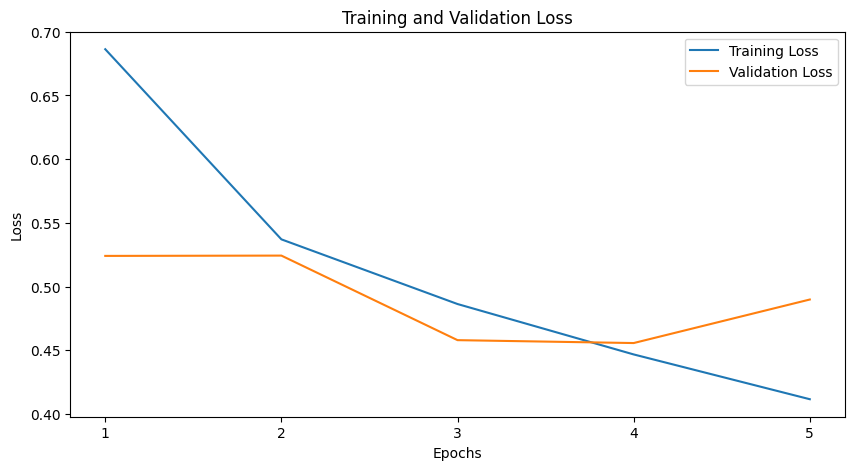

In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

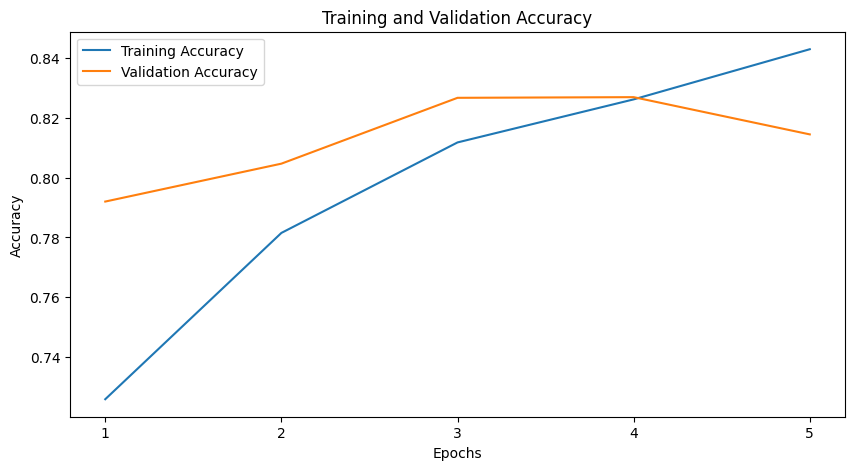

In [27]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

In [28]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0  

model.eval() 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 81.40%
Test Loss: 0.5039


In [31]:
# Confusion matrix  
# Precision, recall, and F1 score
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(true_labels, predicted_labels)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1406   94   31]
 [ 299 1143   10]
 [ 298  143 1076]]

Evaluation Metrics:
Precision: 0.8308
Recall: 0.8056
F1 Score: 0.8066


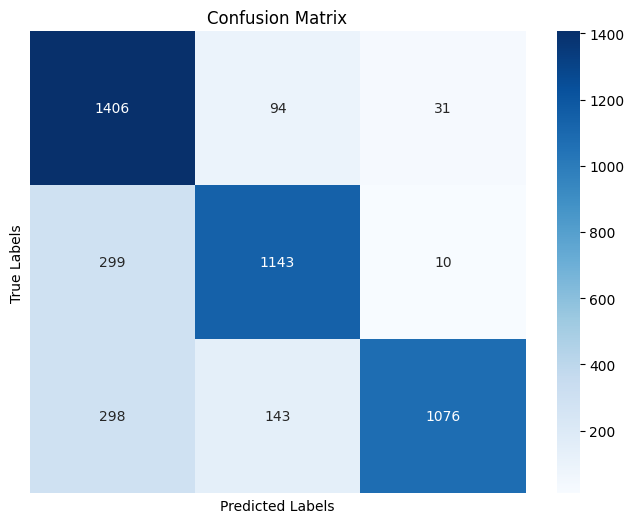

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# Plot confusion matrix without labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## OPTIMIZED MODEL: Regularization, Dropout and Early stopping

In [33]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torch
import torch.nn as nn
import time
import time
import matplotlib.pyplot as plt

In [34]:
# Transformations
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)

In [35]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

Number of images available:  30000
Number of classes:  3


In [36]:
# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500


In [37]:
# Define the basic residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [38]:
# Define the ResNet-18 architecture
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet18_custom():
    return ResNet18(BasicBlock, [2, 2, 2, 2])
model = ResNet18_custom()
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [39]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset.dataset.transform = train_transform

In [40]:
# Optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

In [43]:
from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 5
best_val_loss = float('inf')
patience = 0

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 5: 
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time 

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best_optimized_model.pth')
    else:
        patience += 1
        if patience > 5: 
            print("Early stopping.")
            break

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/5, Total images trained: 1056, Training Accuracy: 83.90%
Epoch 1/5, Total images trained: 2048, Training Accuracy: 83.45%
Epoch 1/5, Total images trained: 3104, Training Accuracy: 83.47%
Epoch 1/5, Total images trained: 4128, Training Accuracy: 83.89%
Epoch 1/5, Total images trained: 5120, Training Accuracy: 83.73%
Epoch 1/5, Total images trained: 6176, Training Accuracy: 84.18%
Epoch 1/5, Total images trained: 7168, Training Accuracy: 84.24%
Epoch 1/5, Total images trained: 8224, Training Accuracy: 84.18%
Epoch 1/5, Total images trained: 9248, Training Accuracy: 84.03%
Epoch 1/5, Total images trained: 10304, Training Accuracy: 83.85%
Epoch 1/5, Total images trained: 11392, Training Accuracy: 83.97%
Epoch 1/5, Total images trained: 12416, Training Accuracy: 84.04%
Epoch 1/5, Total images trained: 13472, Training Accuracy: 83.98%
Epoch 1/5, Total images trained: 14496, Training Accuracy: 83.97%
Epoch 1/5, Total images trained: 15584, Training Accuracy: 83.97%
Epoch 1/5, Total im

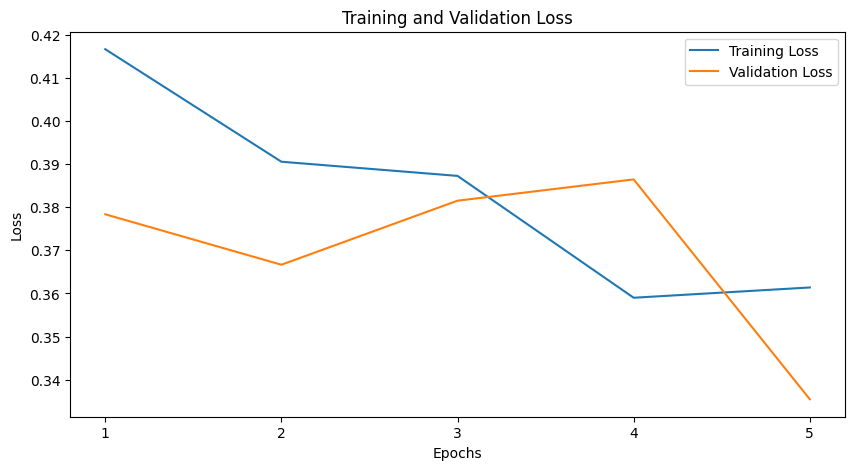

In [44]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

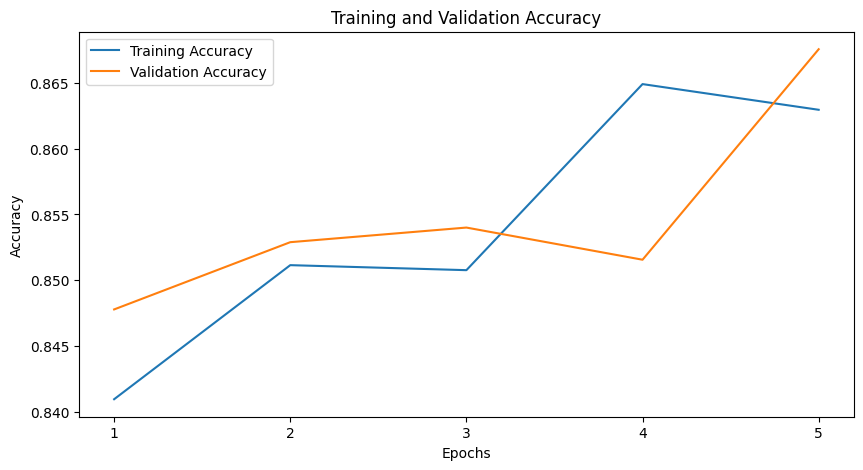

In [45]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

In [46]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0  

model.eval() 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 87.04%
Test Loss: 0.3432


In [47]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [48]:
# Confusion matrix  
# Precision, recall, and F1 score
conf_matrix = confusion_matrix(true_labels, predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1301   82   75]
 [ 214 1212   93]
 [ 125   16 1382]]

Evaluation Metrics:
Precision: 0.8711
Recall: 0.8656
F1 Score: 0.8658


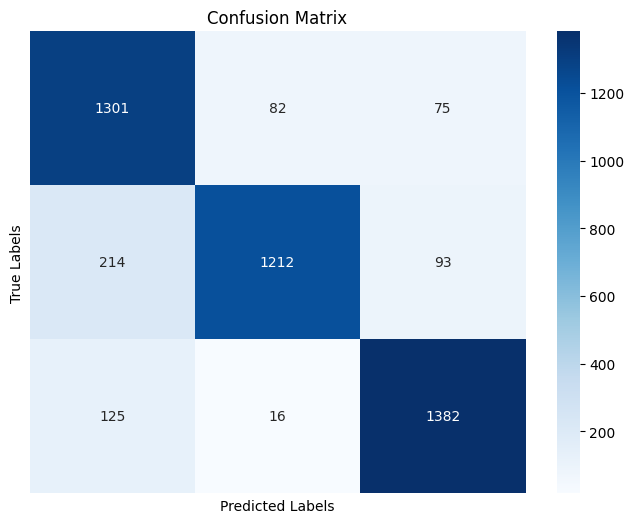

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# Plot confusion matrix without labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()